<a href="https://colab.research.google.com/github/wenhuipeng/Quant/blob/main/02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import os
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.vision.widgets import *

从resource里面才能得到key，不是那个ID
https://portal.azure.com/#@nusu.onmicrosoft.com/resource/subscriptions/48a6e60b-bd29-4773-a739-2c798a78c458/resourceGroups/Bing_Image/providers/Microsoft.Bing/accounts/Wenhui/overview[link text](https://)

https://portal.azure.com/#blade/HubsExtension/BrowseAll


In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '4367880c9c1d4485b227a876dcd6b16c')

In [4]:
search_images_bing

<function fastbook.search_images_bing>

In [5]:
doc(search_images_bing)

In [6]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [7]:
doc(results.attrgot)

In [8]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [9]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

In [11]:
doc(download_url)

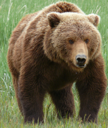

In [12]:
im = Image.open(dest)
im.to_thumb(128,128)

In [13]:
doc(im.to_thumb)

In [14]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [15]:
doc(Path)

In [16]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [17]:
dest

Path('bears/teddy')

In [18]:
fns = get_image_files(path)
fns

(#441) [Path('bears/black/00000041.jpg'),Path('bears/black/00000078.jpg'),Path('bears/black/00000063.jpg'),Path('bears/black/00000072.jpg'),Path('bears/black/00000086.JPG'),Path('bears/black/00000145.png'),Path('bears/black/00000105.jpg'),Path('bears/black/00000121.jpg'),Path('bears/black/00000119.jpg'),Path('bears/black/00000138.jpg')...]

In [19]:
failed = verify_images(fns)
failed

(#1) [Path('bears/teddy/00000101.png')]

In [20]:
failed.map(Path.unlink);

In [21]:
??verify_images

In [22]:
??get_image_files

In [23]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the independent and dependent variables:

blocks=(ImageBlock, CategoryBlock)
The independent variable is the thing we are using to make predictions from, and the dependent variable is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image. We will see many other types of block in the rest of this book.

For this DataLoaders our underlying items will be file paths. We have to tell fastai how to get a list of those files. The get_image_files function takes a path, and returns a list of all of the images in that path (recursively, by default):

get_items=get_image_files
Often, datasets that you download will already have a validation set defined. Sometimes this is done by placing the images for the training and validation sets into different folders. Sometimes it is done by providing a CSV file in which each filename is listed along with which dataset it should be in. There are many ways that this can be done, and fastai provides a very general approach that allows you to use one of its predefined classes for this, or to write your own. In this case, however, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the seed—then you will get the exact same list each time):

splitter=RandomSplitter(valid_pct=0.2, seed=42)

The independent variable is often referred to as x and the dependent variable is often referred to as y. Here, we are telling fastai what function to call to create the labels in our dataset:

get_y=parent_label
parent_label is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a mini-batch). To group them in a big array (usually called a tensor) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. Item transforms are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the Resize transform here:

item_tfms=Resize(128)
This command has given us a DataBlock object. This is like a template for creating a DataLoaders. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [24]:
??get_image_files

This command has given us a DataBlock object. This is like a template for creating a DataLoaders. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [25]:
dls = bears.dataloaders(path)

A DataLoaders includes validation and training DataLoaders. DataLoader is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a DataLoader fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the show_batch method on a DataLoader:

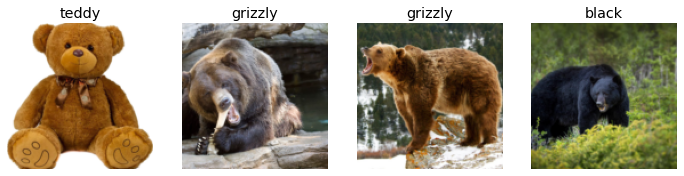

In [26]:
dls.valid.show_batch(max_n=4, nrows=1)

By default Resize crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

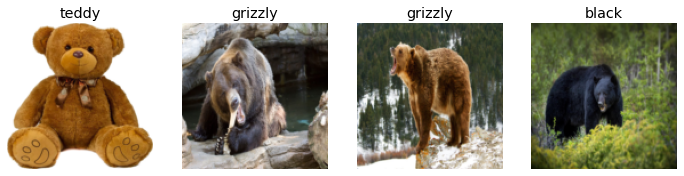

In [27]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

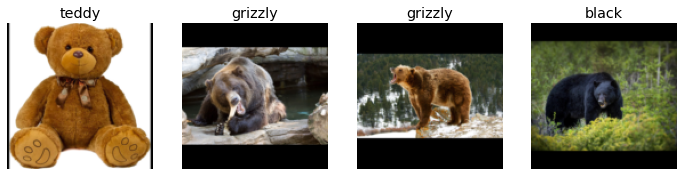

In [28]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace Resize with RandomResizedCrop, which is the transform that provides the behavior we just described. The most important parameter to pass in is min_scale, which determines how much of the image to select at minimum each time:

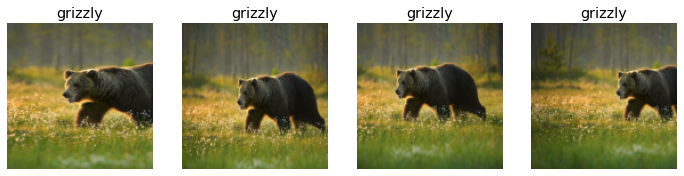

In [29]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# 数据增强

Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the aug_transforms function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms parameter (note that we're not using RandomResizedCrop in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


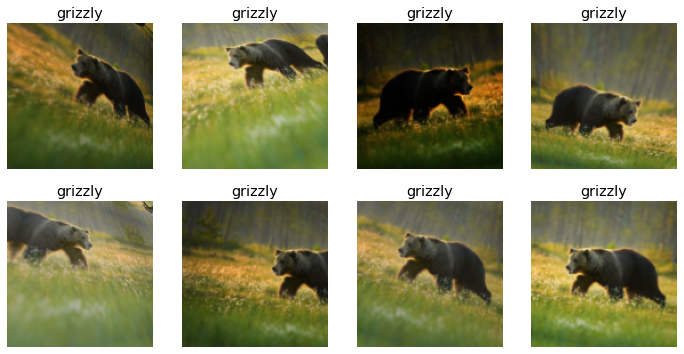

In [30]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# 训练模型

In [31]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [32]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
#fine_tune(4)的4是指4 epochs，4步
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [33]:
doc(learn.fine_tune)

Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a confusion matrix:

显示分类错误的图片的描述

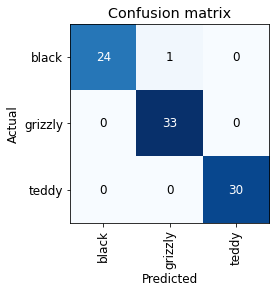

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

显示识别错误的几个图片

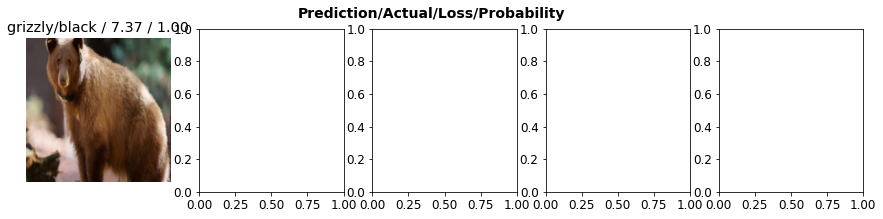

In [38]:
interp.plot_top_losses(5, nrows=1)

帮助清理错误标注的图片的GUI
ImageClassifierCleaner()
这个输出显示，损失最大的图像是一个被预测为 "灰熊 "的图像，其可信度很高。然而，它被标记为（基于我们的Bing图片搜索）"黑色"。我们不是熊专家，但在我们看来，这个标签肯定是不正确的 我们也许应该把它的标签改成 "灰熊"。

做数据清理的直观方法是在训练模型之前做。但正如你在这个案例中所看到的，一个模型实际上可以帮助你更快、更容易地发现数据问题。所以，我们通常倾向于先训练一个快速而简单的模型，然后用它来帮助我们进行数据清洗。

fastai包括一个方便的数据清理GUI，叫做ImageClassifierCleaner，它允许你选择一个类别和训练与验证集，并查看损失最大的图像（按顺序），同时还有菜单允许选择图像进行删除或重新标记。



In [39]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [40]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

我们可以看到，在我们的 "黑熊 "中，有一个图像包含两只熊：一只灰熊，一只黑熊。所以，我们应该在这个图像下的菜单中选择<删除>。ImageClassifierCleaner实际上并不为你做删除或改变标签的工作，它只是返回要改变的项目的索引。因此，举例来说，要删除（取消链接）所有被选中要删除的图像，我们要运行。

In [41]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

要移动我们已经选择了不同类别的图像，我们将运行。

In [42]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

s: 清理数据和为你的模型做好准备是数据科学家的两个最大的挑战；他们说这需要他们90%的时间。fastai库的目的是提供工具，使之尽可能的简单。

我们将在本书中看到更多的模型驱动的数据清理的例子。一旦我们清理了我们的数据，我们就可以重新训练我们的模型。自己试试吧，看看你的准确率是否提高了

注：不需要大数据。在使用这些步骤清理数据集后，我们通常在这项任务上看到100%的准确性。当我们下载的图片比我们在这里使用的每类150张少得多时，我们甚至看到了这个结果。正如你所看到的，通常抱怨说你需要大量的数据来做深度学习，这与事实有很大的差距

现在我们已经训练好了我们的模型，让我们看看如何将其部署在实践中使用。

# 把你的模型变成一个在线应用

我们现在要看一下把这个模型变成一个可以工作的在线应用需要做些什么。我们将只是创建一个基本的工作原型；在本书中，我们没有能力教给你一般的网络应用程序开发的所有细节。

一旦你得到了一个你满意的模型，你需要保存它，这样你就可以把它复制到你将在生产中使用它的服务器上。记住，一个模型由两部分组成：结构和训练的参数。保存模型的最简单方法是保存这两部分，因为这样当你加载一个模型时，你可以确定你有匹配的架构和参数。要保存这两部分，请使用导出方法。

这个方法甚至还保存了如何创建你的DataLoaders的定义。这很重要，因为否则你将不得不重新定义如何转换你的数据，以便在生产中使用你的模型。fastai默认会自动使用你的验证集DataLoader进行推理，因此你的数据增强将不会被应用，这通常是你想要的。

当你调用导出时，fastai将保存一个名为 "export.pkl "的文件。

In [43]:
learn.export()

In [44]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

无论你把你的应用程序部署到哪里，你都需要这个文件。现在，让我们试着在我们的笔记本中创建一个简单的应用程序。

当我们使用一个模型来获得预测，而不是训练，我们称之为推理。为了从导出的文件中创建我们的推理学习器，我们使用load_learner（在这种情况下，这并不是真正必要的，因为我们的笔记本中已经有一个工作的学习器；我们只是在这里做，以便你可以看到整个过程的端到端）。

In [45]:
learn_inf = load_learner(path/'export.pkl')

当我们进行推理时，我们通常只是一次获得一个图像的预测。要做到这一点，需要传递一个文件名给预测。

In [46]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([2.1779e-07, 1.0000e+00, 3.5127e-08]))

这已经返回了三样东西：与你最初提供的格式相同的预测类别（在这种情况下是一个字符串），预测类别的索引，以及每个类别的概率。后两个是基于DataLoaders词汇表中的类别顺序；也就是说，所有可能的类别的存储列表。在推理时，你可以将DataLoaders作为学习者的一个属性来访问。

In [47]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

我们可以看到，如果我们用predict返回的整数对词汇进行索引，那么我们得到的是 "灰熊"，正如预期的那样。另外，请注意，如果我们在概率列表中建立索引，我们看到这是一只灰熊的概率接近1.00。

我们知道如何从我们保存的模型中进行预测，所以我们有了开始建立我们的应用程序所需要的一切。我们可以直接在Jupyter笔记本中进行。

# 下面的均不涉及就没有细看

# Creating a Notebook App from the Model

# Turning Your Notebook into a Real App

# Deploying your app

# How to Avoid Disaster

# Get Writing!

# Questionnaire